<a href="https://colab.research.google.com/github/mobinapourmoshir/Functional-Deep-Learning/blob/main/MNIST_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
##########################
### SETTINGS
##########################

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 123
learning_rate = 0.005
num_epochs = 5
batch_size = 256

# Architecture
num_features = 784
num_hidden_1 = 32


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 39.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.01MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.08MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.39MB/s]

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


In [3]:
##########################
### MODEL
##########################

class Autoencoder(torch.nn.Module):

    def __init__(self, num_features):
        super(Autoencoder, self).__init__()

        ### ENCODER
        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        # The following to lones are not necessary,
        # but used here to demonstrate how to access the weights
        # and use a different weight initialization.
        # By default, PyTorch uses Xavier/Glorot initialization, which
        # should usually be preferred.
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()

        ### DECODER
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_features)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()


    def forward(self, x):

        ### ENCODER
        encoded = self.linear_1(x)
        encoded = F.leaky_relu(encoded)

        ### DECODER
        logits = self.linear_2(encoded)
        decoded = torch.sigmoid(logits)

        return decoded


torch.manual_seed(random_seed)
model = Autoencoder(num_features=num_features)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
##########################
### Training
##########################
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):

        # don't need labels, only the images (features)
        features = features.view(-1, 28*28).to(device)

        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = F.binary_cross_entropy(decoded, features)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                   %(epoch+1, num_epochs, batch_idx,
                     len(train_loader), cost))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

/tmp/ipython-input-2161569568.py:23: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'


Epoch: 001/005 | Batch 000/235 | Cost: 0.7098
Epoch: 001/005 | Batch 050/235 | Cost: 0.2097
Epoch: 001/005 | Batch 100/235 | Cost: 0.1603
Epoch: 001/005 | Batch 150/235 | Cost: 0.1373
Epoch: 001/005 | Batch 200/235 | Cost: 0.1269
Time elapsed: 0.18 min
Epoch: 002/005 | Batch 000/235 | Cost: 0.1193
Epoch: 002/005 | Batch 050/235 | Cost: 0.1110
Epoch: 002/005 | Batch 100/235 | Cost: 0.1079
Epoch: 002/005 | Batch 150/235 | Cost: 0.1037
Epoch: 002/005 | Batch 200/235 | Cost: 0.1032
Time elapsed: 0.34 min
Epoch: 003/005 | Batch 000/235 | Cost: 0.1022
Epoch: 003/005 | Batch 050/235 | Cost: 0.1025
Epoch: 003/005 | Batch 100/235 | Cost: 0.0992
Epoch: 003/005 | Batch 150/235 | Cost: 0.0955
Epoch: 003/005 | Batch 200/235 | Cost: 0.0965
Time elapsed: 0.50 min
Epoch: 004/005 | Batch 000/235 | Cost: 0.0986
Epoch: 004/005 | Batch 050/235 | Cost: 0.0964
Epoch: 004/005 | Batch 100/235 | Cost: 0.0988
Epoch: 004/005 | Batch 150/235 | Cost: 0.0973
Epoch: 004/005 | Batch 200/235 | Cost: 0.0931
Time elapse

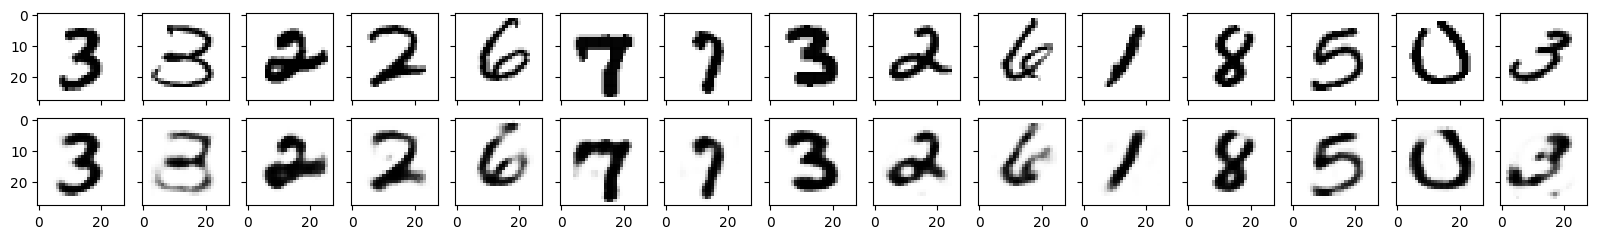

In [5]:
##########################
### Evaluation
##########################
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images,
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')